## FDTree Class

In [1]:
import time
import klepto
import shelve
import pickle
import numpy as np
from scipy.sparse import *

In [2]:
rating_matrix_csc = load_npz('netflix/sparse_matrix_100%.npz').tocsc()
rating_matrix_val_csc = load_npz('netflix/sparse_matrix_validation_75%.npz').tocsc()
print("file load DONE")

file load DONE


In [3]:
start = 0
end = int(rating_matrix_csc.shape[1] * 0.75)

## Step 1: Input Dataset

In [4]:
class DecisionTreeModel:
    def __init__(self, source, depth_threshold=10, plambda=7, MSP_item=200):
        
        self.sMatrix = source
        self.depth_threshold = depth_threshold
        self.plambda = plambda
        self.MSP_item = MSP_item

        #### Calculate rate of progress ####
        self.cur_depth = 0
        self.node_num = 0
        self.cur_node = 0
        for i in range(self.depth_threshold):
            self.node_num += 3 ** i
        
        #### Initiate Tree, lr_bound ####
        self.tree = list(range(1, self.sMatrix.shape[1]))
        self.split_item = []
        self.lr_bound = {'0': [[0, len(self.tree) - 1]]}

        #### Generate bias, sum_cur_t, sum_2_cur_t ####
        #### Generate rI, rU ####        
        self.rU = {}        
        for dictname in range(151):
            d = shelve.open('./rU_data/'+str(dictname), protocol = pickle.HIGHEST_PROTOCOL)
            self.rU.update(d['content'])
            d.close()
        print("rU DONE")
        
#         self.biasUM = load_npz('netflix/biasUM.npz').tocsc()
#         print("biasUM DONE")
        
        Tree = klepto.archives.dir_archive('treeFile', {}, serialized=True)
        Tree.load()
        self.biasU       = Tree["biasU"]
        self.sum_cur_t   = Tree["sum_cur_t"]
        self.sum_2_cur_t = Tree["sum_2_cur_t"]
        self.sum_cntt    = Tree["sum_cntt"]
        self.rI          = Tree["rI"]
        self.item_size = self.sMatrix.shape[0]
        self.user_size = len(self.tree)        
        print("Initiation DONE!")

    def calculate_error(self, sumt, sumt_2, cntt):
        ''' Calculate error for one item-split in one node '''
        Error_i = np.sum(sumt_2 - (sumt ** 2) / (cntt + 1e-9))

        return Error_i

    def generate_decision_tree(self, lr_bound_for_node, chosen_id):
        #### Terminate ####
        self.cur_depth += 1
        if self.cur_depth > self.depth_threshold or len(chosen_id) == self.item_size:
            return        
        #### Choose Most Popular Items of This Node ####
        num_rec = np.zeros(self.item_size)
        for userid in self.tree[lr_bound_for_node[0]:(lr_bound_for_node[1] + 1)]:
            user_all_rating_id = np.array(list(self.rU[userid].keys()))
            num_rec[user_all_rating_id] += 1
        sub_item_id = np.argsort(-num_rec)[:self.MSP_item]
        #### Find optimum item to split ####
        min_sumtL, min_sumtD, min_sumtL_2, min_sumtD_2, min_sumtU, min_sumtU_2, Error = {}, {}, {}, {}, {}, {}, {}
        min_Error = "None"
        for itemid in sub_item_id:
            if itemid in chosen_id:
                continue
            '''
                user_rating_item_in_nodet: np.array([ [uid01, rating01], [uid02, rating02], ... ])
                to find all users in node t who rates item i
            '''           
            user_rating_item_in_nodet = np.array([[userid, self.rU[userid][itemid]] for userid in
                                         self.tree[lr_bound_for_node[0]:(lr_bound_for_node[1] + 1)] if
                                         itemid in self.rU[userid]])
#             sumt = np.zeros((self.item_size, 3))
#             sumt_2 = np.zeros((self.item_size, 3))
#             cntt = np.zeros((self.item_size, 3))

#             lst_L = list(user_rating_item_in_nodet[user_rating_item_in_nodet[:, 1] >= 4, 0])
#             lst_D = list(user_rating_item_in_nodet[user_rating_item_in_nodet[:, 1] <= 3, 0])

#             realML = self.sMatrix[:, lst_L] - self.biasUM[:, lst_L]
#             realMD = self.sMatrix[:, lst_D] - self.biasUM[:, lst_D]
#             sumt[:, 0] = (realML).sum(axis=1).T
#             sumt_2[:, 0] = (realML.power(2)).sum(axis=1).T
#             cntt[:, 0] = self.sMatrix[:, lst_L].getnnz(axis=1).T
#             sumt[:, 1] = (realMD).sum(axis=1).T
#             sumt_2[:, 1] = (realMD.power(2)).sum(axis=1).T
#             cntt[:, 1] = self.sMatrix[:, lst_L].getnnz(axis=1).T            
            sumt = np.zeros((self.item_size, 3))
            sumt_2 = np.zeros((self.item_size, 3))
            cntt = np.zeros((self.item_size, 3))
            for user in user_rating_item_in_nodet:
                ''' user_all_rating: array [ [itemid11, rating11], [itemid12, rating12], ... ] '''
                user_all_rating_id = np.array(list(self.rU[user[0]].keys()))
                user_all_rating = np.array(list(self.rU[user[0]].values()))
                #### calculate sumtL for node LIKE ####
                if user[1] >= 4:
                    sumt[user_all_rating_id[:], 0] += user_all_rating[:] - self.biasU[user[0]]
                    sumt_2[user_all_rating_id[:], 0] += (user_all_rating[:] - self.biasU[user[0]]) ** 2
                    cntt[user_all_rating_id[:], 0] += 1
                #### calculate sumtD for node DISLIKE ####
                elif user[1] <= 3:
                    sumt[user_all_rating_id[:], 1] += user_all_rating[:] - self.biasU[user[0]]
                    sumt_2[user_all_rating_id[:], 1] += (user_all_rating[:] - self.biasU[user[0]]) ** 2
                    cntt[user_all_rating_id[:], 1] += 1

            #### calculate sumtU for node UNKNOWN ####
            sumt[:, 2] = self.sum_cur_t[:] - sumt[:, 0] - sumt[:, 1]
            sumt_2[:, 2] = self.sum_2_cur_t[:] - sumt_2[:, 0] - sumt_2[:, 1]
            cntt[:, 2] = self.sum_cntt[:] - cntt[:, 0] - cntt[:, 1]
            Error[itemid] = self.calculate_error(sumt, sumt_2, cntt)

            if min_Error == "None" or Error[itemid] < min_Error:
                min_sumt = sumt
                min_sumt_2 = sumt_2
                min_cntt = cntt
                min_Error = Error[itemid]
        #### Find optimum split-item ####
        optimum_itemid = min(Error, key=Error.get)
        if len(self.split_item) == self.cur_depth - 1:
            self.split_item.append([optimum_itemid])
        else:
            self.split_item[self.cur_depth - 1].append(optimum_itemid)
        # self.split_item.setdefault(str(self.cur_depth-1), []).append(optimum_itemid)
        chosen_id.append(optimum_itemid)
        print("split item found!")
        #### sort tree ####
        self.lr_bound.setdefault(str(self.cur_depth), []).append([])  # for LIKE
        self.lr_bound[str(self.cur_depth)].append([])  # for DISLIKE
        self.lr_bound[str(self.cur_depth)].append([])  # for UNKNOWN
        listU, listL, listD = [], [], []
        for userid in self.tree[lr_bound_for_node[0]:(lr_bound_for_node[1] + 1)]:
            if optimum_itemid not in self.rU[userid]:
                listU.append(userid)
            elif self.rU[userid][optimum_itemid] >= 4:
                listL.append(userid)
            elif self.rU[userid][optimum_itemid] <= 3:
                listD.append(userid)
        self.tree[lr_bound_for_node[0]:(lr_bound_for_node[1] + 1)] = listL + listD + listU
        self.lr_bound[str(self.cur_depth)][-3] = [lr_bound_for_node[0],
                                                  lr_bound_for_node[0] + len(listL) - 1]  # for LIKE
        self.lr_bound[str(self.cur_depth)][-2] = [lr_bound_for_node[0] + len(listL),
                                                  lr_bound_for_node[0] + len(listL) + len(listD) - 1]  # for DISLIKE
        self.lr_bound[str(self.cur_depth)][-1] = [lr_bound_for_node[0] + len(listL) + len(listD),
                                                  lr_bound_for_node[0] + len(listL) + len(listD) + len(listU) - 1]  # for UNKNOWN

        #### Generate Subtree of Node LIKE ####
        self.sum_cur_t = min_sumt[:, 0]
        self.sum_2_cur_t = min_sumt_2[:, 0]
        self.sum_cntt = min_cntt[:, 0]
        self.generate_decision_tree(self.lr_bound[str(self.cur_depth)][-3], chosen_id[:])
        self.cur_depth -= 1

        #### Generate Subtree of Node DISLIKE ####
        self.sum_cur_t = min_sumt[:, 1]
        self.sum_2_cur_t = min_sumt_2[:, 1]
        self.sum_cntt = min_cntt[:, 1]
        self.generate_decision_tree(self.lr_bound[str(self.cur_depth)][-2], chosen_id[:])
        self.cur_depth -= 1

        #### Generate Subtree of Node UNKNOWN ####
        self.sum_cur_t = min_sumt[:, 2]
        self.sum_2_cur_t = min_sumt_2[:, 2]
        self.sum_cntt = min_cntt[:, 2]
        self.generate_decision_tree(self.lr_bound[str(self.cur_depth)][-1], chosen_id[:])
        self.cur_depth -= 1

        #### Show Rating Progress ####
        for i in range(self.cur_depth - 1):
            print("┃", end="")
        print("┏", end="")
        self.cur_node += 1
        print("Current depth: " + str(self.cur_depth) + "        %.2f%%" % (100 * self.cur_node / self.node_num))

    def build_model(self):
        #### Construct the tree & get the prediction model ####
        self.generate_decision_tree(self.lr_bound['0'][0], [])

## Tree Init

In [5]:
dtmodel_realdata = DecisionTreeModel(rating_matrix_csc[:, start:end], depth_threshold = 10)

rU DONE
Initiation DONE!


## Build Tree

In [ ]:
dtmodel_realdata.build_model()

[    0 13755 11148 11344  4806  6256 11936  8146 12418 16875  4711 16155
 13405 10581  4362 10597  9507  9124 12107  8964   820  3656 15197 13064
  4294  4338 16354 15587 15571 11500  9549 11838 12363 10640  4614  8858
 12964   915 16542  2805 12681  5486  9647 10840  7030  1445  7717  5161
 10011  5452 15521  9250 10398  6991  3693  2537 15202  6074 10578  5349
  9196  8057 13980 14710 13478  7068  6734  1416 15051 10902  7497  7375
  2291  7231  8018  4035 14518  9566 15199   392  3790 13950  8934  7388
   149  8305 16996  3578   272  6711  1858  6527  2367 16408  3853  1003
  5260 11360  8965  3328  1247 14071 16111  4797 10807 10549  9490  5615
  1591  5975  7842  5193  9742 15682 14743  1383 14548  5494  7372  4880
  2744 14490  6426  6393  1198  5619  5584 10049  4605 10931  3069 17336
 16013  2725  9172  1952  6539  6743  4574 14125  7522 12341 12829  9979
 15789 13759  8723 10546 10427 15056  5500  5923 15656 15665 17660  6894
  8059 12204  4837  6059  4457  2745  7480  8459  3

In [9]:
Tree = klepto.archives.dir_archive('treeFile', cached=True, serialized=True)

Tree['fmps_lr_bound'] = dtmodel_realdata.lr_bound
Tree['fmps_tree'] = dtmodel_realdata.tree
Tree['fmps_split_item'] = dtmodel_realdata.split_item

Tree.dump()
Tree.clear()

In [8]:
time.localtime(time.time())
time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time()))

'2017-11-09 08:30:39'

In [10]:
del dtmodel_realdata

## MF part

In [4]:
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.mllib.recommendation import ALS

class MatrixFactorization:
    def __init__(self, maxIter=15, regParam=0.01, rank=10):
        self.maxIter = maxIter
        self.regParam = regParam
        self.rank = rank
        conf = SparkConf().setAppName("appName").setMaster("local[*]")
        conf.set("spark.driver.memory","8g")
        conf.set("spark.executor.memory","8g")
        self.spark = SparkContext(conf=conf)
                    
        print("New SparkSession started...")

    def change_parameter(self, regParam):
        self.regParam = regParam

    def matrix_factorization(self, train_lst):
        ratings = self.spark.parallelize(train_lst)
        print('create dataframe!')
        model = ALS.train(ratings, self.rank, seed=10, \
                          iterations=self.maxIter, \
                          lambda_=self.regParam)
        print("MF DONE")
        userFeatures = sorted(model.userFeatures().collect(), key=lambda d: d[0], reverse=False)
        productFeatures = sorted(model.productFeatures().collect(), key=lambda d: d[0], reverse=False)
        userProfile = {each[0]: each[1].tolist() for each in userFeatures}
        itemProfile = {each[0]: each[1].tolist() for each in productFeatures}
        
        
        return userProfile, itemProfile

    def end(self):
        self.spark.stop()
        print("SparkSession stopped.")

## Tool Function

In [5]:
val_num = rating_matrix_val_csc.getnnz(axis=None)
########################################## For Validation #############################################
def calculate_avg_rating_for_pesudo_user(pseudo_user_lst, sMatrix):

    ret_array = np.zeros(sMatrix.shape[0])
    ret_array = np.array(sMatrix[:, pseudo_user_lst].sum(axis=1))[:,0]/(sMatrix[:, pseudo_user_lst].getnnz(axis=1)+1e-9)

    return ret_array


def pred_RMSE_for_validate_user(user_node_ind, user_profile, item_profile, val_user_list, val_item_list, sMatrix):
    print("RMSE calculation on valset started.")
    RMSE = 0
    i = 0
    for userid, itemid in zip(val_user_list, val_item_list):
        if i % 100000 == 0:
            print("%.2f%%" % (100 * i / val_num))        
        i += 1
        RMSE += (sMatrix[itemid, userid] - np.dot(user_profile[user_node_ind[userid]], item_profile[itemid]))**2
    return (RMSE / len(val_user_list))**0.5

def generate_prediction_model(lr_bound, tree, rI, sMatrix, plambda_candidates, validation_set):
    ''' lr_bound: dict {
                level 0: [[left_bound, right_bound]], users' bound for one level, each ele in dictionary represents one node
                level 1: [[left_bound, right_bound], [left_bound, right_bound], [left_bound, right_bound]], 3
                level 2: ..., 9
            } (bound means index)
        plambda_candidates: {
            level 0: [clambda1, clambda2, clambda3, ...]
            level 1: [clambda1, clambda2, clambda3, ...]
            level 2: [clambda1, clambda2, clambda3, ...]
        }
        prediction_model: dict {
                level 0: { 'best_lambda': x, 'user_profile': ..., 'item_profile': ...}
                level 1: { 'best_lambda': x, 'user_profile': ..., 'item_profile': ...}
                level 2: { 'best_lambda': x, 'user_profile': ..., 'item_profile': ...}
            }
    '''
    MF = MatrixFactorization()
    prediction_model = {}
    rmst_dict = {"0":[],
                     "1":[],
                     "2":[],
                     "3":[],
                     "4":[],
                     "5":[],
                     "6":[],
                     "7":[],
                     "8":[],
                     "9":[],
                     "10":[]}
    
    val_item_list = find(validation_set)[0]
    val_user_list = find(validation_set)[1]
    user_node_ind = np.zeros(sMatrix.shape[1])                  #### notice that index is not id
    
    for level in lr_bound:
        level = "1"
        if int(level) >= 6:
            continue 
        print("level:", level)
        prediction_model.setdefault(level, {})
        train_lst = []       
        for pseudo_user_bound, userid in zip(lr_bound[level], range(len(lr_bound[level]))):
            if pseudo_user_bound[0] > pseudo_user_bound[1]:
                continue
            pseudo_user_lst = tree[pseudo_user_bound[0]:(pseudo_user_bound[1] + 1)]
            pseudo_user_for_item = calculate_avg_rating_for_pesudo_user(pseudo_user_lst, sMatrix)
            train_lst += [(userid, itemid, float(pseudo_user_for_item[itemid])) \
                          for itemid in range(pseudo_user_for_item.shape[0]) if pseudo_user_for_item[itemid]]    
            #### find node index for each validation user ####
            user_node_ind[pseudo_user_lst] = userid      

        print("Rating Number of level " + level + ": " + str(len(train_lst)))
        #### Train MF and Do validation ####
        min_RMSE = -1
        for plambda in plambda_candidates[level]:
            print(plambda)
            MF.change_parameter(plambda)
            user_profile, item_profile = MF.matrix_factorization(train_lst)
            RMSE = pred_RMSE_for_validate_user(user_node_ind, user_profile, item_profile, val_user_list, val_item_list, validation_set)
            rmst_dict[level].append(RMSE)
            if min_RMSE is -1 or RMSE < min_RMSE:
                min_RMSE = RMSE
                min_user_profile, min_item_profile, min_lambda = user_profile, item_profile, plambda_candidates[level]
                
        print("min_lambda: " + str(min_lambda))
        print("min_RMSE: " + str(min_RMSE))

        import matplotlib.pyplot as plt

        plt.figure(1)
        plt.title('avg RMSE for each iteration')
        plt.xlabel('plambda')
        plt.ylabel('avg RMSE')
        plt.plot(prediction_model[level], rmst_dict[level])
        plt.show()

        prediction_model[level]['upro'], prediction_model[level]['ipro'], prediction_model[level]['plambda'] \
                                             = min_user_profile, min_item_profile, min_lambda
        print("level " + level + " training DONE")
    
    MF.end()
    return prediction_model

## Load Tree from file

In [6]:
import klepto
import numpy as np
Tree = klepto.archives.dir_archive('treeFile', {}, serialized=True)
Tree.load()

In [7]:
plambda_candidates = {"0":[0.0015, 0.0016, 0.0017, 0.0018, 0.0019, 0.001, 0.0011, 0.0012, 0.0013, 0.0014],
                     "1":[0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.015, 0.020, 0.03, 0.04],
                     "2":[0.001, 0.0011, 0.0012, 0.0013, 0.0014, 0.0015, 0.0016, 0.0017, 0.0018, 0.0019],
                     "3":[0.001, 0.0011, 0.0012, 0.0013, 0.0014, 0.0015, 0.0016, 0.0017, 0.0018, 0.0019],
                     "4":[0.0021, 0.0022, 0.0023, 0.0024, 0.0025, 0.0026, 0.0027, 0.0028, 0.0029, 0.030],
                     "5":[0.0021, 0.0022, 0.0023, 0.0024, 0.0025, 0.0026, 0.0027, 0.0028, 0.0029, 0.030],
                     "6":[0.009, 0.01, 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018, 0.019],
                     "7":[0.009, 0.01, 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018, 0.019],
                     "8":[0.018, 0.019, 0.02, 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027, 0.028],
                     "9":[0.018, 0.019, 0.02, 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027, 0.028],
                     "10":[0.018, 0.019, 0.02, 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027, 0.028]}
# for level in Tree["lr_bound"]:
#     plambda_candidates[level] = list(np.arange(0.001, 0.05, 0.005))    

New SparkSession started...
level: 1
Rating Number of level 1: 53303
0.005
create dataframe!
MF DONE
RMSE calculation on valset started.
0.00%
9.47%
18.93%
28.40%
37.86%
47.33%
56.79%
66.26%
75.73%
85.19%
94.66%
0.006
create dataframe!
MF DONE
RMSE calculation on valset started.
0.00%
9.47%
18.93%
28.40%
37.86%
47.33%
56.79%
66.26%
75.73%
85.19%
94.66%
0.007
create dataframe!
MF DONE
RMSE calculation on valset started.
0.00%
9.47%
18.93%
28.40%
37.86%
47.33%
56.79%
66.26%
75.73%
85.19%
94.66%
0.008
create dataframe!
MF DONE
RMSE calculation on valset started.
0.00%
9.47%
18.93%
28.40%
37.86%
47.33%
56.79%
66.26%
75.73%
85.19%
94.66%
0.009
create dataframe!
MF DONE
RMSE calculation on valset started.
0.00%
9.47%
18.93%
28.40%
37.86%
47.33%
56.79%
66.26%
75.73%
85.19%
94.66%
0.01
create dataframe!
MF DONE
RMSE calculation on valset started.
0.00%
9.47%
18.93%
28.40%
37.86%
47.33%
56.79%
66.26%
75.73%
85.19%
94.66%
0.015
create dataframe!
MF DONE
RMSE calculation on valset started.
0.00%


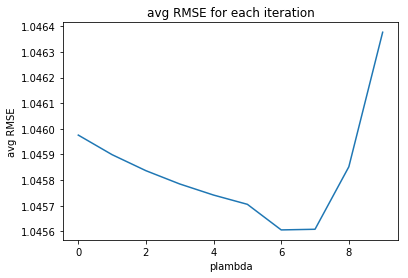

level 1 training DONE
level: 1
Rating Number of level 1: 53303
0.005
create dataframe!
MF DONE
RMSE calculation on valset started.
0.00%
9.47%
18.93%
28.40%
37.86%
47.33%
56.79%


KeyboardInterrupt: 

In [8]:
prediction_model = generate_prediction_model \
            (Tree['lr_bound'], \
             Tree['tree'], \
             Tree['rI'], \
             rating_matrix_csc[:, start:end], 
             plambda_candidates, 
             rating_matrix_val_csc)    

In [20]:
import klepto
Tree = klepto.archives.dir_archive('treeFile', cached=True, serialized=True)
Tree['prediction_model'] = prediction_model
Tree.dump()
Tree.clear()

In [ ]:
def RMSE(real_rating, pred_rating, rated_item):
    
    non_zeros = list(np.nonzero(real_rating)[0])
    non_zeros = list(set(non_zeros).difference(set(rated_item)))
    rmse = (np.sum((pred_rating[non_zeros].T[0]-real_rating[non_zeros])**2) / (len(non_zeros)))**0.5
#     print(len(non_zeros))
#     print(real_rating[non_zeros])
#     print(pred_rating[non_zeros])
#     print((pred_rating[non_zeros]-real_rating[non_zeros])**2)
#     print(np.sum((pred_rating[non_zeros]-real_rating[non_zeros])**2))
#     print((pred_rating[non_zeros]-real_rating[non_zeros]))
#     print(rmse)
    return rmse


def predict(user_profile, item_profile):
    ''' 
        user_profile: array {
                        [k1, k2, k3, ... , kt]
                    } profile for certain user
        item_profile: dict {
                        itemid1: [k1, k2, k3, ... , kt], 
                        itemid2: [k1, k2, k3, ... , kt], 
                        itemid3: [k1, k2, k3, ... , kt], 
                    } profile for items in each node
     '''
    #### Calculate predict rating ####
    pred_rating = np.dot(item_profile, user_profile)
    
    return pred_rating

def pred_RMSE_for_new_user(split_item, rI, prediction_model, sM_testing):
    '''
        sM_testing: 30% test dataset (sparse matrix)
        split_item: list [
                level 0: [112],
                level 1: [48, 0, 79],
                level 2: [15, 0, 17, 1, 1, 1, 61, 0, 50]
                ...
            ]
        User: dict {
                    userid1: { itemid11: rating11, itemid12: rating12, ... } rating of user 1
                    userid2: { itemid21: rating21, itemid22: rating22, ... } rating of user 2
                    userid3: ...
                }
        return : rmse value (float)
    '''

    sM_testing_0_discard = sM_testing[1:,:]
    rmse = 0
    for userid in range(sM_testing.shape[1]):
        if userid % 100 == 0:
            print("%.2f%%" % (100 * userid / sM_testing.shape[1]))  
        pred_index = 0
        final_level = 0
        rated_item = []
        user_all_ratings = sM_testing[:,userid].nonzero()[0]
#         print("Step1 start:")
        for level in range(len(split_item)):
            if split_item[level][pred_index] not in user_all_ratings:
                tmp_pred_index = 3*pred_index + 2
                if tmp_pred_index in prediction_model[str(int(level)+1)]['upro']:
                    final_level += 1
                    pred_index = tmp_pred_index
                else:
                    break
            elif sM_testing[split_item[level][pred_index], userid] >= 4:
                tmp_pred_index = 3*pred_index
                if tmp_pred_index in prediction_model[str(int(level)+1)]['upro']:
                    rated_item.append(split_item[level][pred_index]-1)
                    final_level += 1
                    pred_index = tmp_pred_index
                else:
                    break
            elif sM_testing[split_item[level][pred_index], userid] <= 3:
                tmp_pred_index = 3*pred_index + 1
                if tmp_pred_index in prediction_model[str(int(level)+1)]['upro']:
                    rated_item.append(split_item[level][pred_index]-1)
                    final_level += 1
                    pred_index = tmp_pred_index
                else:
                    break        
#         print("Step2 start:")
        pred_rating = predict(np.array(prediction_model[str(final_level)]['upro'][pred_index]), \
                                            np.array(list(prediction_model[str(final_level)]['ipro'].values()))) 
#         print("Step3 start:")
#         print(pred_rating)
#         print(sM_testing_0_discard[:, userid].toarray())
        rmse += RMSE(sM_testing_0_discard[:, userid].toarray(), pred_rating, rated_item)
    return rmse / sM_testing.shape[1]
#######################################################################################################

In [ ]:
import klepto
import numpy as np
Tree = klepto.archives.dir_archive('treeFile', {}, serialized=True)
Tree.load()

In [ ]:
rmse_result = pred_RMSE_for_new_user(Tree['split_item'], Tree["rI"], prediction_model, rating_matrix_csc[:, end:])

In [14]:
rmse_result

1.1750985993864183